<a href="https://colab.research.google.com/github/ronald-hk-chung/torch-step/blob/main/Computer%20Vision/class_activation_maps_CAMS_dogcat_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating CAMs (Class Activation Maps) for image classification problems
1. Decide for which class you want to claculate the CAM and for which convolutional layer in the neural network you want to compute the CAM
2. Calculate the activations arising from any convolutional layers - lets say the feature shape at a random convolution layer is 512x7x7
3. Fetch the gradient values arising from this layer wiht repect to the class of interest. The output gradient shape is 256x512x3x3 (which is the shape of the convolutional tensor - that is , in-channels x out-channels x kernel-size x kernel size
4. Compute the mean of the gradients wihtin each output channel. the output shape is 512
5. Calculate the weighted activation map - which is the muliplication of 512 gradient means by the 512 activation channels. The output shape is 512x7x7
6. Compute the mean (across 512 channels) of the weighted activation map to fetch an output of the shape 7x7
7. Resize (upscale) the weighted activation map outputs to fetch an image of a size that is of the same size as the input. This is done so that we have an activation map that resembles the original image.
8. Overlay the weighted activation map onto the input image

The key to the entire process lies in step 5. We consider two aspects of the step:
* If a certain pixel is important, then the CNN will have a large activation at those pixels
* If a certain convolutional channel is important with respect to the required class, the gradients at that channel will be very large

Multiplying these two, we will end up with a map of importance across all the pixels

## Import necessary packages

In [1]:
import datetime
import random
import os, pathlib, shutil
from pathlib import Path
import zipfile
import gdown
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torchvision import datasets, transforms
from torchvision.transforms import v2 as T
from torch.utils.data import DataLoader, Dataset
from torch import nn
try:
  import torchinfo
except:
  !pip install -q torchinfo
  import torchinfo
try:
  from duckduckgo_search import DDGS
except:
  ! pip install -q duckduckgo_search
  from duckduckgo_search import DDGS

torch_step_URL = 'https://raw.githubusercontent.com/ronald-hk-chung/torch-step/main/TorchStep/torch_step.py'
with open('torch_step.py', 'wb') as f:
  f.write(requests.get(torch_step_URL).content)
from torch_step import TSEngine

vision_utils_URL = 'https://raw.githubusercontent.com/ronald-hk-chung/torch-step/main/TorchStep/vision_utils.py'
with open('vision_utils.py', 'wb') as f:
  f.write(requests.get(vision_utils_URL).content)
from vision_utils import get_pretrained_model, collect_images, validate_images, get_cam, show_batch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 53.2 MB/s eta 0:00:00


## Using Duckduckgo to download images of cats and dogs

In [2]:
# Download images using ddg
dog_results = collect_images(keywords='Dogs', path='data/Dogs', max_results=200)
cat_results = collect_images(keywords='Cats', path='data/Cats', max_results=200)

  0%|          | 0/200 [00:00<?, ?it/s]

[INFO] Downloaded 167 images into data/Dogs


  0%|          | 0/200 [00:00<?, ?it/s]

[INFO] Downloaded 175 images into data/Cats


## Prepare pretrained model

In [3]:
# Download pretrained resnet50
model_resnet34, tfms_resnet34, rtfms_resnet34 = \
  get_pretrained_model(name='resnet34',
                       pretrained_weights='ResNet34_Weights.IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 204MB/s]


## Prepare dataset and dataloaders with pretrained_transformation

In [4]:
data_path = Path('data')
df = pd.DataFrame(list(data_path.rglob('*.jpg')),columns=['path'])
df['class_names'] = df['path'].apply(lambda x: x.parent.name)
class_names = list(set(df['class_names']))
df['classes'] = df['class_names'].apply(lambda x: [float(class_name == x) for class_name in class_names])
class_names

['Dogs', 'Cats']

In [5]:
from sklearn.model_selection import train_test_split
df_train, df_valid = train_test_split(df, test_size=0.2)

In [6]:
class DGDataset(Dataset):
  def __init__(self, df, tfms):
    self.df = df
    self.tfms = tfms
  def __len__(self):
    return len(self.df)
  def __getitem__(self, idx):
    img = self.tfms(Image.open(self.df.iloc[idx].path).convert('RGB'))
    label = torch.tensor(self.df.iloc[idx].classes, dtype=torch.float32)
    return img, label

In [7]:
train_ds = DGDataset(df=df_train,
                     tfms=tfms_resnet34)
valid_ds = DGDataset(df=df_valid,
                     tfms=tfms_resnet34)

train_dl = DataLoader(dataset=train_ds,
                      batch_size=32,
                      shuffle=True,
                      num_workers=os.cpu_count(),
                      pin_memory=True)
valid_dl = DataLoader(dataset=valid_ds,
                      batch_size=32,
                      shuffle=False,
                      num_workers=os.cpu_count(),
                      pin_memory=True)

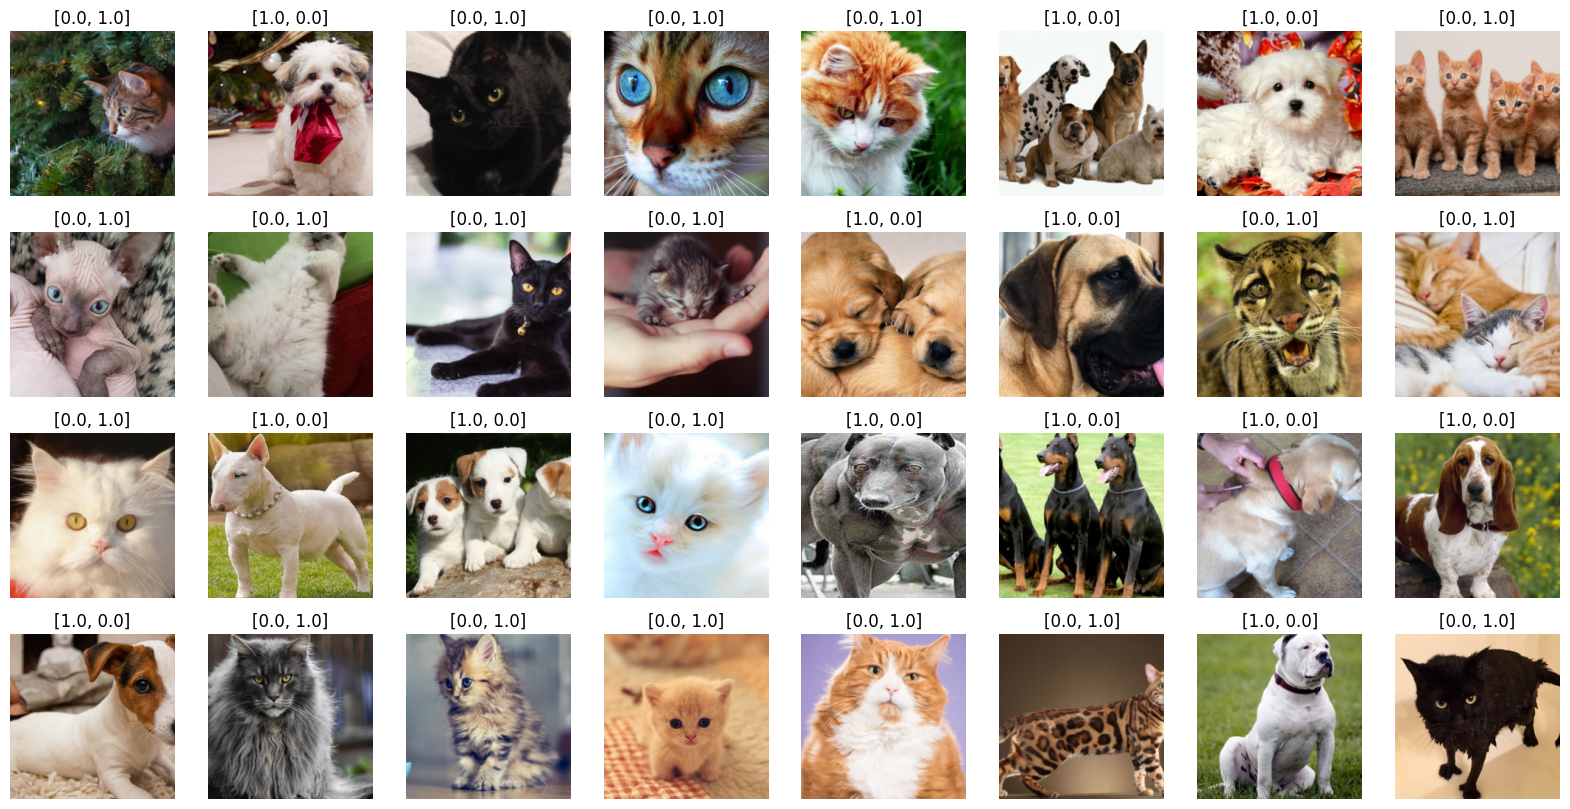

In [8]:
show_batch(train_dl, rtfms_resnet34, lambda x: x[0].tolist())

## Prepare model and Train Engine

In [9]:
# develop AGRClassifier to replace fc
class DGClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.classifier = nn.Sequential(nn.Linear(512, 128),
                                    nn.ReLU(),
                                    nn.BatchNorm1d(128),
                                    nn.Dropout(0.4),
                                    nn.Linear(128, 32),
                                    nn.ReLU(),
                                    nn.BatchNorm1d(32),
                                    nn.Dropout(0.4),
                                    nn.Linear(32, 2),
                                    nn.Sigmoid())

  def forward(self, X):
    X = self.classifier(X).squeeze()
    return X

In [10]:
model_resnet34.fc = DGClassifier()

In [11]:
def accuracy(y_logits, y):
  return tuple((y_logits[:,i].round()==y[:,i]).sum().item()/len(y[:,i]) for i in range(len(y[0])))

In [12]:
# Putting into TSEngine for training
DGClassifier = TSEngine(model=model_resnet34,
                        optim=(torch.optim.Adam, {'lr': 1e-3}),
                        loss_fn=nn.BCELoss(),
                        metric_fn=accuracy,
                        train_dataloader=train_dl,
                        valid_dataloader=valid_dl)

In [13]:
DGClassifier.freeze()
DGClassifier.unfreeze(['fc'])

In [14]:
DGClassifier.model_info()

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 2]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (36,864)             False
│    │    

In [15]:
DGClassifier.train(3)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | LR: 1.0E-03 | train_loss: 0.592 | valid_loss: 0.497 | train_metric: [0.696 0.665] | valid_metric: [0.948 0.969] 
Epoch: 2 | LR: 1.0E-03 | train_loss: 0.378 | valid_loss: 0.304 | train_metric: [0.914 0.9  ] | valid_metric: [0.969 0.969] 
Epoch: 3 | LR: 1.0E-03 | train_loss: 0.299 | valid_loss: 0.207 | train_metric: [0.941 0.934] | valid_metric: [0.969 0.969] 


In [16]:
DGClassifier.save_checkpoint('DG.pt')

In [34]:
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRUCLbjE4rN_mhu1KBje5OXiSi3zBiOmb7l9g&usqp=CAU'
with open('test.jpg', 'wb') as f:
  f.write(requests.get(url).content)

Prediction: tensor([0.7564, 0.1959], device='cuda:0', grad_fn=<SqueezeBackward0>)


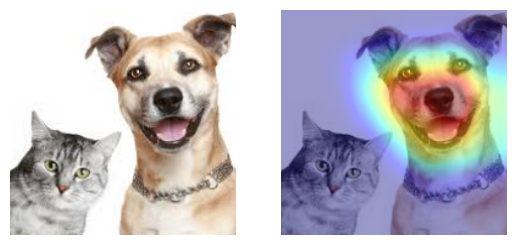

In [35]:
# Getting CAM for class 0 Dogs
get_cam(img_path='test.jpg',
        tfms=tfms_resnet34,
        rtfms=rtfms_resnet34,
        classifier=DGClassifier,
        layers_to_activate=['layer4.2'],
        class_to_activate=0)

Prediction: tensor([0.7564, 0.1959], device='cuda:0', grad_fn=<SqueezeBackward0>)


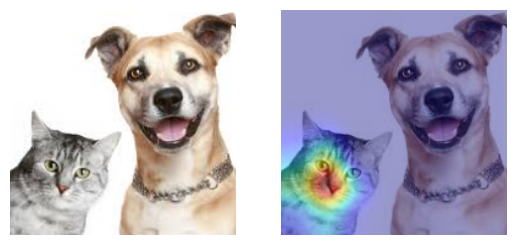

In [36]:
# Getting CAM for class 1 Cats
get_cam(img_path='test.jpg',
        tfms=tfms_resnet34,
        rtfms=rtfms_resnet34,
        classifier=DGClassifier,
        layers_to_activate=['layer4.2'],
        class_to_activate=1)